# Research for AI Data analysis.
This document provides a comprehensive overview of our project. However, it's important to note that this isn't the complete story. Our journey involved restarting the project several times due to encountered challenges. Specifically, we went through the training, validation, and analysis process three times. The content presented here is the outcome of our third attempt. Initially, we encountered image-related issues that skewed our results, necessitating a fresh start. Then, during our second attempt, we discovered a sampling error influencing all our results, prompting us to restart from scratch.

Before arriving at the analysis detailed below, we undertook the following steps:

- Initially, we labeled all images using Roboflow.
- We then developed and executed several scripts, experiencing various challenges along the way:
-- 1-split_images.py: Set up different scenarios' folders and conducted resampling.
-- 2-yolo_train.py: Trained all the models.
-- 3-copy_val.py: Replaced the original validation set with a 27-image set, covering all three scenarios.
-- 4-yolo_val.py: Conducted validation for all models using a 75-image set, repeated twice with 0.25 and 0.9 settings.
-- 5-get_info.py: Extracted all metrics from training and validation, generating CSV files for this analysis.

The following analysis is the result of extensive preparatory work, involving numerous graphs and tables that preceded it.

# Import data

In [2]:
!pip install gdown==4.6.0

In [1]:
import gdown
url = "https://drive.google.com/drive/folders/1253ShTP74KHbGv6Ta10q1DWPZy3C_fgk?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['c:\\Users\\bcrui\\Documents\\Yolov8\\AIResearch\\results_all7.csv',
 'c:\\Users\\bcrui\\Documents\\Yolov8\\AIResearch\\results_val_all7.csv',
 'c:\\Users\\bcrui\\Documents\\Yolov8\\AIResearch\\results_val_all8.csv',
 'c:\\Users\\bcrui\\Documents\\Yolov8\\AIResearch\\resultso_train100.csv',
 'c:\\Users\\bcrui\\Documents\\Yolov8\\AIResearch\\resultso_val100-09.csv',
 'c:\\Users\\bcrui\\Documents\\Yolov8\\AIResearch\\resultso_val100-025.csv']

# Imports and subroutines

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,
                         "No of Levels":data.apply(lambda x: x.nunique(),axis=0), 
                         "Levels":data.apply(lambda x: str(x.unique()),axis=0)})

## settings

In [5]:
graph_dir = r'./AIResearch/Graphs/'
errorbar = 'ci'

# SCENARIOS 
Size Variations, Different Positions, Partial Visibility

## Visualize Training results

In [6]:
results=pd.read_csv("AIResearch/results_all7.csv")
#inspect_data(results)

In [7]:
# Trim spaces from column names
results.columns = [col.strip() for col in results.columns]

#add F1 score
results['metrics/F1']=(2*results['metrics/precision(B)']*results['metrics/recall(B)'])/(results['metrics/precision(B)']+results['metrics/recall(B)'])

#filter on epoch 25, with the lowest loss
results_fil=results[results['epoch'] == 25].copy()

#Change values, so they can be sorted
change_map = {'SL_20_5_125': '1-SL_20_5_125', 'SL_40_10_100': '2-SL_40_10_100','SL_60_15_75': '3-SL_60_15_75','SL_80_20_50': '4-SL_80_20_50','SL_100_25_25': '5-SL_100_25_25'}
results_fil['dataset'] = results_fil['dataset'].map(change_map).fillna(results_fil['dataset'])


#Group by Experiment en Dataset en get the mean for the metrics over the 10 runs
results_fil.groupby(['experiment','dataset'])[['metrics/F1','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']].mean().sort_values(['experiment','dataset','metrics/F1'])

experiment_map = {'Oclussie':'Partial Visibility',
                  'Size':'Size Variations',
                  'Position':'Different Positions'
    
}
results_fil['experiment'] = results_fil['experiment'].replace(experiment_map)
#inspect_data(results_fil)

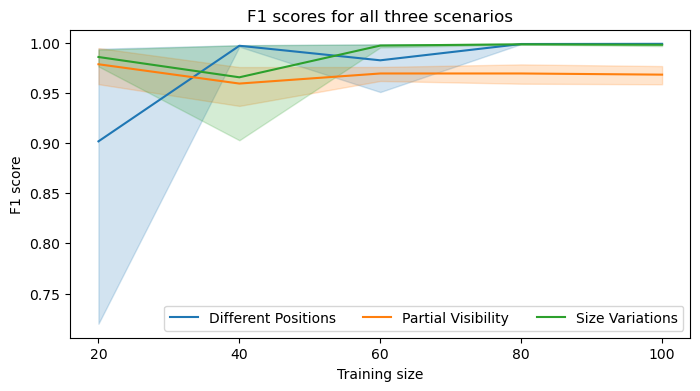

In [8]:
plt.figure(figsize=(8, 4))
sns.lineplot(results_fil.sort_values(by=['dataset']), x='dataset', y='metrics/F1', hue='experiment',errorbar=errorbar)
my_xticks = [20, 40, 60, 80, 100]

plt.xticks(np.arange(len(my_xticks)), my_xticks)
plt.xlabel('Training size')
plt.ylabel('F1 score')
#plt.ylim(0.4, 1.0)
plt.title("F1 scores for all three scenarios")
plt.legend(ncol=3, loc = 'lower right')
plt.savefig(graph_dir+"F1_scores_scenarios.png")
plt.show()

## Visualize Validation results

In [9]:
results_val025=pd.read_csv("AIResearch/results_val_all7.csv")
results_val090=pd.read_csv("AIResearch/results_val_all8.csv")


results_val025['conf'] = '0.25'
results_val090['conf'] = '0.90'

results_val = pd.concat([results_val025,results_val090], ignore_index=True)
results_val.drop(columns = 'Unnamed: 0', axis=1, inplace = True)
#inspect_data(results_val)

In [10]:
change_map = {'SL_20_5_125': '1-SL_20_5_125', 'SL_40_10_100': '2-SL_40_10_100','SL_60_15_75': '3-SL_60_15_75','SL_80_20_50': '4-SL_80_20_50','SL_100_25_25': '5-SL_100_25_25'}

# Trim spaces from column names
results_val.columns = [col.strip() for col in results_val.columns]

# #add F1 score
results_val['metrics/F1']=(2*results_val['metrics/precision(B)']*results_val['metrics/recall(B)'])/(results_val['metrics/precision(B)']+results_val['metrics/recall(B)'])

# #Change values, so they can be sorted
results_val['dataset'] = results_val['dataset'].map(change_map).fillna(results_val['dataset'])

# #Group by Experiment en Dataset en get the mean for the metrics over the 10 runs
results_val.groupby(['experiment','dataset'])[['metrics/F1','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']].mean().sort_values(['experiment','dataset','metrics/F1'])

experiment_map = {'Oclussie':'Partial Visibility',
                  'Size':'Size Variations',
                  'Position':'Different Positions'
    
}
results_val['experiment']= results_val['experiment'].replace(experiment_map)

results_val['series'] = results_val['experiment'] + ' - conf= ' + results_val['conf']

#inspect_data(results_val)

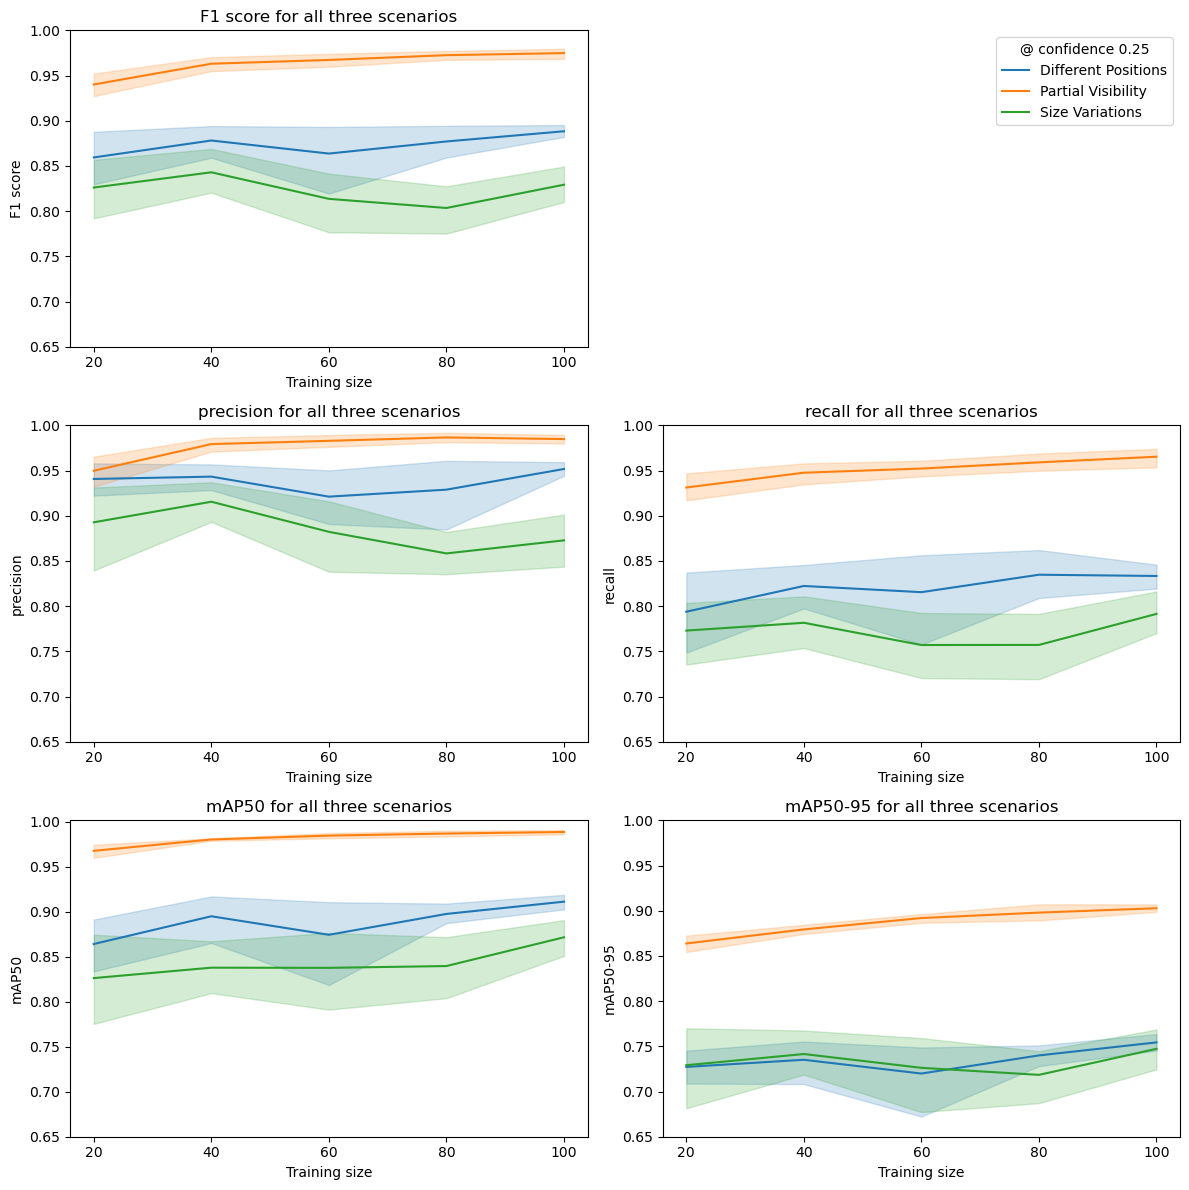

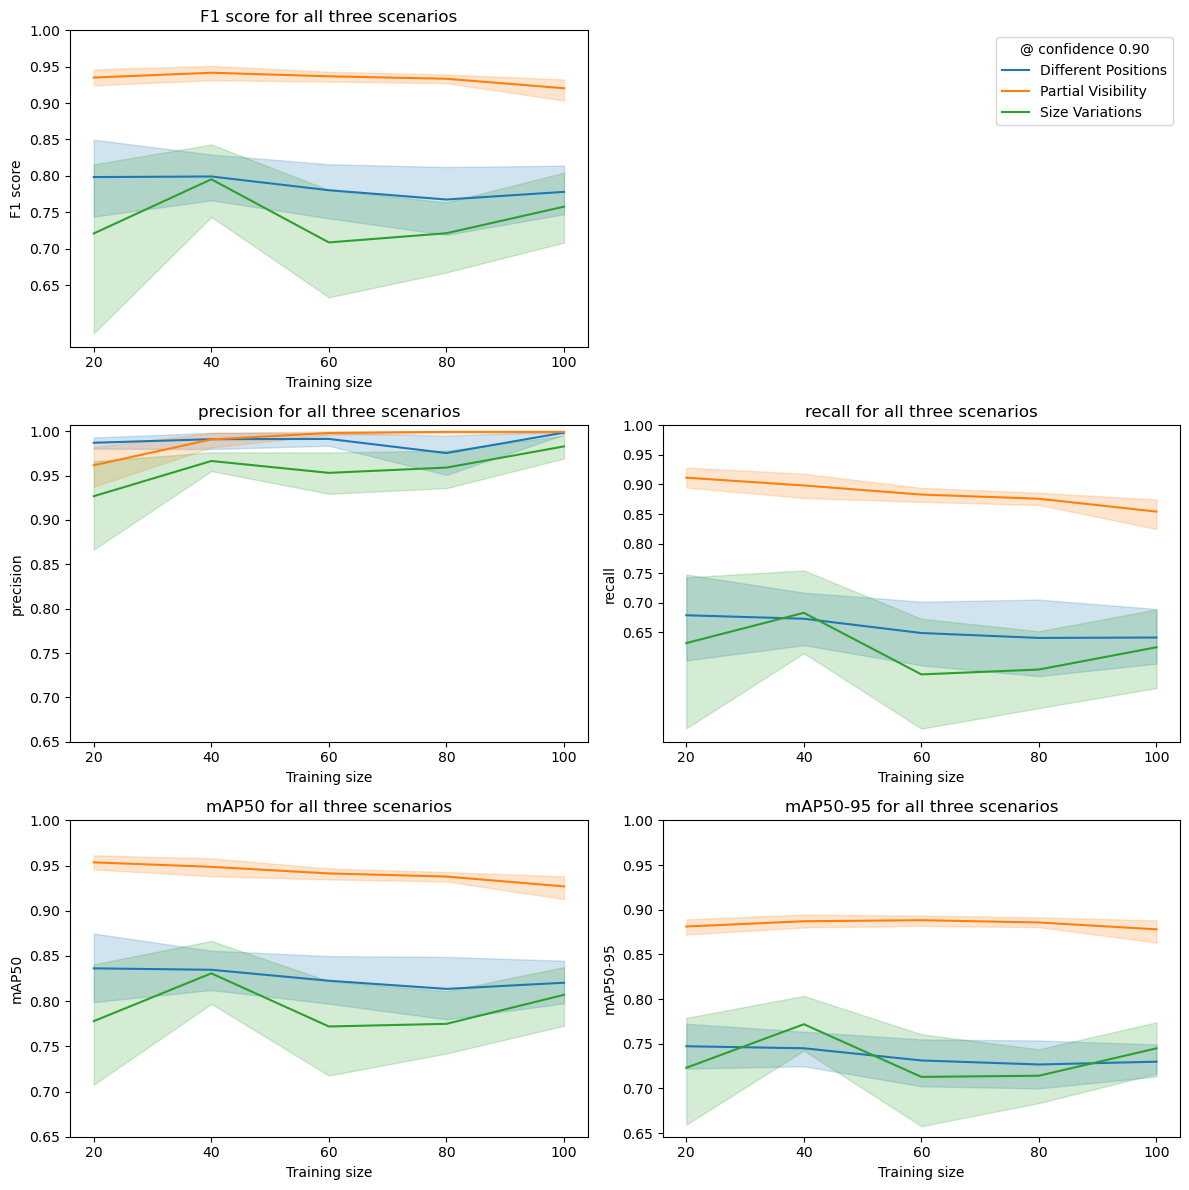

In [11]:
columns  = ['metrics/F1','None','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']
label_columns = ['F1 score','None','precision','recall','mAP50','mAP50-95']

my_xticks = [20, 40, 60, 80, 100]


for conf_label in results_val['conf'].unique():
    fig, axes = plt.subplots(3,2, figsize =(12,12))
    handles, lables = (None,None)
    for i, ax in enumerate(axes.flatten()):

        if columns[i] == 'None':
            ax.legend(handles, labels, title='@ confidence '+conf_label)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

        else:
            sns.lineplot(results_val[results_val['conf']==conf_label].sort_values(by=['dataset','series']), x='dataset', y=columns[i], hue='experiment', ax=ax, errorbar = errorbar)

            ax.set_xticks(np.arange(len(my_xticks)), my_xticks)
            ax.set_xlabel('Training size')
            ax.set_ylabel(label_columns[i])
            ax.set_title(label_columns[i]+ " for all three scenarios")
            ax.set_yticks(np.arange(0.65, 1.05, 0.05))
            #ax.set_ylim(0.85, 1.05, 0.1)
            #ax.set_xticks(rotation=45)
            if columns[i] == 'None':
                ax.set_visible(False)
            #ax.legend(False)
            if i == 0:
                handles, labels = ax.get_legend_handles_labels()
            ax.legend().remove()

    plt.tight_layout()
    plt.savefig(graph_dir+"metrics_scenarios_conf"+conf_label+".png")
    plt.show()


# Training set 10 vs 100

## Visualize Training results

In [12]:
results_100=pd.read_csv("AIResearch/resultso_train100.csv")
results_10=pd.read_csv("AIResearch/results_all7.csv")

results_10 = results_10[results_10['experiment'] == 'Oclussie']

results_100['experiment'] = '100 models'
results_10['experiment'] = '10 models'

results = pd.concat([results_100, results_10], ignore_index=True)
results.drop(columns = 'Unnamed: 0', axis=1, inplace = True)
#inspect_data(results)

In [13]:
# Trim spaces from column names
results.columns = [col.strip() for col in results.columns]

#add F1 score
results['metrics/F1']=(2*results['metrics/precision(B)']*results['metrics/recall(B)'])/(results['metrics/precision(B)']+results['metrics/recall(B)'])

#filter on epoch 25, with the lowest loss
results_fil=results[results['epoch'] == 25].copy()

#Change values, so they can be sorted
change_map = {'SL_20_5_125': '1-SL_20_5_125', 'SL_40_10_100': '2-SL_40_10_100','SL_60_15_75': '3-SL_60_15_75','SL_80_20_50': '4-SL_80_20_50','SL_100_25_25': '5-SL_100_25_25'}
results_fil['dataset'] = results_fil['dataset'].map(change_map).fillna(results_fil['dataset'])

#Group by Experiment en Dataset en get the mean for the metrics over the 10 runs
results_fil.groupby(['experiment','dataset'])[['metrics/F1','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']].mean().sort_values(['experiment','dataset','metrics/F1'])

#inspcet_data(results_fil)

metrics/F1  metrics/precision(B)  \
experiment dataset                                            
10 models  1-SL_20_5_125     0.978461              0.983507   
           2-SL_40_10_100    0.959223              0.960804   
           3-SL_60_15_75     0.969264              0.961772   
           4-SL_80_20_50     0.969268              0.970562   
           5-SL_100_25_25    0.968111              0.976994   
100 models 1-SL_20_5_125     0.959155              0.966510   
           2-SL_40_10_100    0.966359              0.972363   
           3-SL_60_15_75     0.971597              0.974751   
           4-SL_80_20_50     0.972598              0.973500   
           5-SL_100_25_25    0.974002              0.972487   

                           metrics/recall(B)  metrics/mAP50(B)  \
experiment dataset                                               
10 models  1-SL_20_5_125            0.974790          0.980638   
           2-SL_40_10_100           0.958779          0.975518   
           3-SL_60_15_75            0.977421          0.989657   
           4-SL_80_20_50            0.968682          0.986999   
           5-SL_100_25_25           0.960014          0.989172   
100 models 1-SL_20_5_125            0.955185          0.968623   
           2-SL_40_10_100           0.961621          0.979278   
           3-SL_60_15_75            0.968926          0.987657   
           4-SL_80_20_50            0.972066          0.989088   
           5-SL_100_25_25           0.975804          0.990107   

                           metrics/mAP50-95(B)  
experiment dataset                              
10 models  1-SL_20_5_125              0.905158  
           2-SL_40_10_100             0.887713  
           3-SL_60_15_75              0.898994  
           4-SL_80_20_50              0.907716  
           5-SL_100_25_25             0.912438  
100 models 1-SL_20_5_125              0.878289  
           2-SL_40_10_100             0.895438  
           3-SL_60_15_75              0.906258  
           4-SL_80_20_50              0.911219  
           5-SL_100_25_25             0.918916

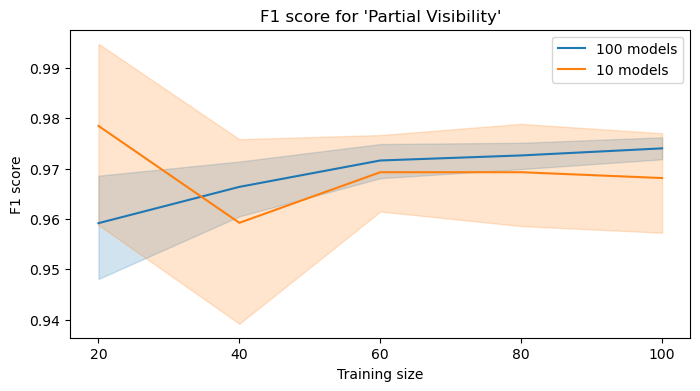

In [14]:
plt.figure(figsize=(8, 4))
sns.lineplot(results_fil.sort_values(by='dataset'), x='dataset', y='metrics/F1', hue='experiment', errorbar=errorbar)
my_xticks = [20, 40, 60, 80, 100]
plt.xticks(np.arange(len(my_xticks)), my_xticks)
plt.xlabel('Training size')
plt.ylabel('F1 score')
plt.title("F1 score for 'Partial Visibility'")
plt.legend()
plt.savefig(graph_dir+"F1_scores_compared.png")
plt.show()

# Visualize Validation results 10 vs 100

read all results for training of 10 models and 100 models, both for confidence factor 0.25 and 0.9

create one data frame and rename the experiment columns

In [15]:
results_val025_100=pd.read_csv("AIResearch/resultso_val100-025.csv")
results_val090_100=pd.read_csv("AIResearch/resultso_val100-09.csv")
results_val025_10=pd.read_csv("AIResearch/results_val_all7.csv")
results_val090_10=pd.read_csv("AIResearch/results_val_all8.csv")


results_val025_100['experiment'] = 'Confidence 0.25 100 models'#100_conf_025'
results_val090_100['experiment'] = 'Confidence 0.90 100 models'#'100_conf_090'
results_val025_10 = results_val025_10[results_val025_10['experiment'] == 'Oclussie']
results_val090_10 = results_val090_10[results_val090_10['experiment'] == 'Oclussie']

results_val025_10['experiment'] = 'Confidence 0.25 10 models' # '10_conf_025'
results_val090_10['experiment'] = 'Confidence 0.90 10 models' #'10_conf_090 '

results_val = pd.concat([results_val025_10, results_val025_100, results_val090_10, results_val090_100], ignore_index=True)
results_val.drop(columns = 'Unnamed: 0', axis=1, inplace = True)
#inspect_data(results_val)

In [16]:
change_map = {'SL_20_5_125': '1-SL_20_5_125', 'SL_40_10_100': '2-SL_40_10_100','SL_60_15_75': '3-SL_60_15_75','SL_80_20_50': '4-SL_80_20_50','SL_100_25_25': '5-SL_100_25_25'}

# Trim spaces from column names
results_val.columns = [col.strip() for col in results_val.columns]

# #add F1 score
results_val['metrics/F1']=(2*results_val['metrics/precision(B)']*results_val['metrics/recall(B)'])/(results_val['metrics/precision(B)']+results_val['metrics/recall(B)'])

# #Change values, so they can be sorted
results_val['dataset'] = results_val['dataset'].map(change_map).fillna(results_val['dataset'])

# #Group by Experiment en Dataset en get the mean for the metrics over the 10 runs
results_val.groupby(['experiment','dataset'])[['metrics/F1','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']].mean().sort_values(['experiment','dataset','metrics/F1'])
#inspect_data(results_val)

metrics/F1  metrics/precision(B)  \
experiment                 dataset                                            
Confidence 0.25 10 models  1-SL_20_5_125     0.940102              0.949740   
                           2-SL_40_10_100    0.963068              0.979245   
                           3-SL_60_15_75     0.967232              0.982852   
                           4-SL_80_20_50     0.972522              0.986617   
                           5-SL_100_25_25    0.974824              0.984775   
Confidence 0.25 100 models 1-SL_20_5_125     0.941709              0.957682   
                           2-SL_40_10_100    0.950866              0.963933   
                           3-SL_60_15_75     0.963230              0.977330   
                           4-SL_80_20_50     0.968145              0.977850   
                           5-SL_100_25_25    0.976082              0.986672   
Confidence 0.90 10 models  1-SL_20_5_125     0.935144              0.961659   
                           2-SL_40_10_100    0.941720              0.990778   
                           3-SL_60_15_75     0.936835              0.998022   
                           4-SL_80_20_50     0.933458              0.999324   
                           5-SL_100_25_25    0.920424              0.999333   
Confidence 0.90 100 models 1-SL_20_5_125     0.930357              0.971883   
                           2-SL_40_10_100    0.931708              0.978435   
                           3-SL_60_15_75     0.934734              0.990644   
                           4-SL_80_20_50     0.935894              0.993393   
                           5-SL_100_25_25    0.923885              0.999191   

                                           metrics/recall(B)  \
experiment                 dataset                             
Confidence 0.25 10 models  1-SL_20_5_125            0.931203   
                           2-SL_40_10_100           0.947602   
                           3-SL_60_15_75            0.952181   
                           4-SL_80_20_50            0.959034   
                           5-SL_100_25_25           0.965301   
Confidence 0.25 100 models 1-SL_20_5_125            0.927017   
                           2-SL_40_10_100           0.940527   
                           3-SL_60_15_75            0.949959   
                           4-SL_80_20_50            0.959163   
                           5-SL_100_25_25           0.965900   
Confidence 0.90 10 models  1-SL_20_5_125            0.911465   
                           2-SL_40_10_100           0.898298   
                           3-SL_60_15_75            0.882941   
                           4-SL_80_20_50            0.875882   
                           5-SL_100_25_25           0.854118   
Confidence 0.90 100 models 1-SL_20_5_125            0.893705   
                           2-SL_40_10_100           0.892602   
                           3-SL_60_15_75            0.885811   
                           4-SL_80_20_50            0.885647   
                           5-SL_100_25_25           0.859529   

                                           metrics/mAP50(B)  \
experiment                 dataset                            
Confidence 0.25 10 models  1-SL_20_5_125           0.967812   
                           2-SL_40_10_100          0.980438   
                           3-SL_60_15_75           0.984716   
                           4-SL_80_20_50           0.987039   
                           5-SL_100_25_25          0.988774   
Confidence 0.25 100 models 1-SL_20_5_125           0.967421   
                           2-SL_40_10_100          0.971364   
                           3-SL_60_15_75           0.979689   
                           4-SL_80_20_50           0.984224   
                           5-SL_100_25_25          0.988896   
Confidence 0.90 10 models  1-SL_20_5_125           0.953516   
                           2-SL_40_10_100          0.948553   
             

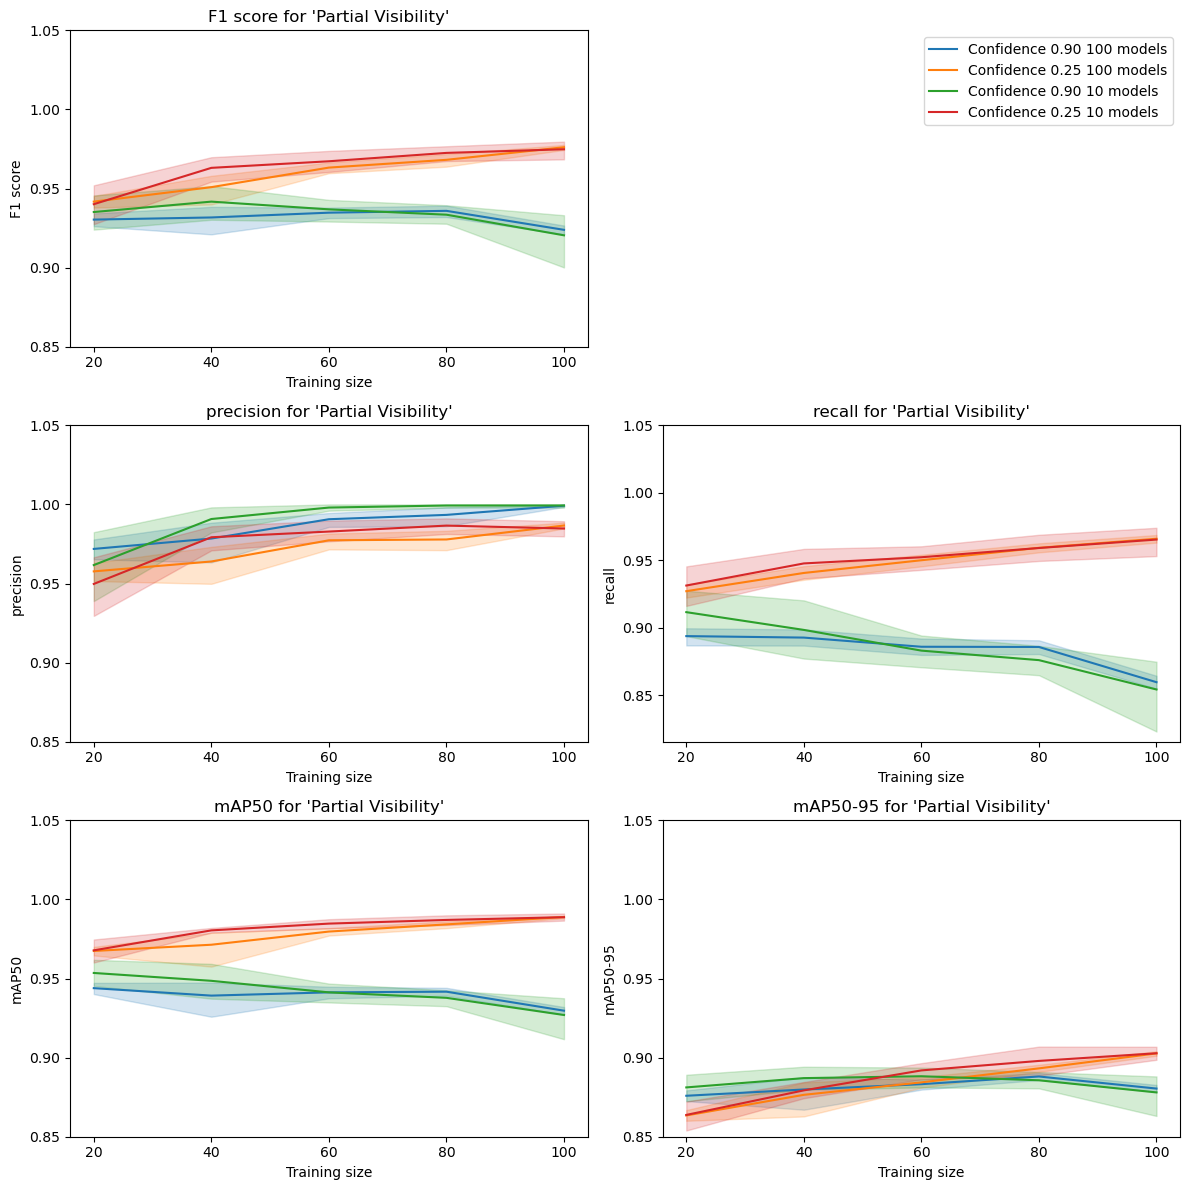

In [17]:
columns  = ['metrics/F1','None','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']
label_columns = ['F1 score','None','precision','recall','mAP50','mAP50-95']

my_xticks = [20, 40, 60, 80, 100]

fig, axes = plt.subplots(3,2, figsize =(12,12))
handles, lables = (None,None)
for i, ax in enumerate(axes.flatten()):
    
    if columns[i] == 'None':
        ax.legend(handles, labels)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        
    else:
        sns.lineplot(results_val.sort_values(by='dataset'), x='dataset', y=columns[i], hue='experiment', ax=ax, errorbar = errorbar)
        
        ax.set_xticks(np.arange(len(my_xticks)), my_xticks)
        ax.set_xlabel('Training size')
        ax.set_ylabel(label_columns[i])
        ax.set_title(label_columns[i]+ " for 'Partial Visibility'")
        ax.set_yticks(np.arange(0.85, 1.05, 0.05))
        #ax.set_ylim(0.85, 1.05, 0.1)
        #ax.set_xticks(rotation=45)
        if columns[i] == 'None':
            ax.set_visible(False)
        #ax.legend(False)
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()

plt.tight_layout()
plt.savefig(graph_dir+"metrics_100vs10.png")
plt.show()

    

# Statistics
This part focuses on the Partially visible set with 5 x 100 models

In [18]:
results100=pd.read_csv("AIResearch/resultso_val100-025.csv")

 ## First we focus on the 0.25 threshold

In [20]:
# Trim spaces from column names
results100.columns = [col.strip() for col in results100.columns]

#add F1 score
results100['metrics/F1']=(2*results100['metrics/precision(B)']*results100['metrics/recall(B)'])/(results100['metrics/precision(B)']+results100['metrics/recall(B)'])
results100.head()

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,dataset,run,metrics/F1
0,0.980229,0.976471,0.990350,0.904803,0.913358,SL_100_25_25,0,0.978346
1,0.994006,0.975422,0.993681,0.904035,0.913000,SL_100_25_25,1,0.984626
2,0.993926,0.962603,0.993099,0.897091,0.906692,SL_100_25_25,10,0.978014
3,0.993696,0.970588,0.987652,0.900228,0.908970,SL_100_25_25,11,0.982006
4,0.994040,0.981113,0.992299,0.913124,0.921042,SL_100_25_25,12,0.987534


General statistics

In [21]:
filtered_sets = ['SL_20_5_125', 'SL_40_10_100', 'SL_60_15_75', 'SL_80_20_50', 'SL_100_25_25']

for set_value in filtered_sets:
    results_filtered = results100[results100['dataset'] == set_value]

    se = np.std(results_filtered['metrics/F1']) / np.sqrt(len(results_filtered['metrics/F1']))
    mean = np.mean(results_filtered['metrics/F1'])

    print(f'Set of {set_value}, Mean: {mean:.3f}, Standard Error: {se:.3f}, '
          f'CI: {(mean - 1.96 * se):.3f}, {(mean + 1.96 * se):.3f}')

Set of SL_20_5_125, Mean: 0.942, Standard Error: 0.002, CI: 0.938, 0.946
Set of SL_40_10_100, Mean: 0.951, Standard Error: 0.005, CI: 0.942, 0.960
Set of SL_60_15_75, Mean: 0.963, Standard Error: 0.002, CI: 0.960, 0.967
Set of SL_80_20_50, Mean: 0.968, Standard Error: 0.002, CI: 0.964, 0.972
Set of SL_100_25_25, Mean: 0.976, Standard Error: 0.001, CI: 0.975, 0.978


In [25]:
from scipy import stats

filtered_sets = ['SL_40_10_100', 'SL_60_15_75', 'SL_80_20_50', 'SL_100_25_25']
results_min = results100[results100['dataset'] == 'SL_20_5_125']

for set_value in filtered_sets:
  results_filtered = results100[results100['dataset'] == set_value]
  t_statistic, p_value = stats.ttest_ind(results_filtered['metrics/F1'], results_min['metrics/F1'], equal_var=True, alternative='greater')
  print(f'{set_value} significally bigger than SL_20_5_125: t={t_statistic:.3f}, p={p_value:.3f}')

SL_40_10_100 significally bigger than SL_20_5_125: t=1.765, p=0.040
SL_60_15_75 significally bigger than SL_20_5_125: t=7.891, p=0.000
SL_80_20_50 significally bigger than SL_20_5_125: t=9.299, p=0.000
SL_100_25_25 significally bigger than SL_20_5_125: t=16.198, p=0.000


## Heatmap p-values F1 scores, conf=0.25

In [26]:
sets =  ['SL_20_5_125', 'SL_40_10_100', 'SL_60_15_75', 'SL_80_20_50', 'SL_100_25_25']


set1_vals = []
for set1 in sets:
    set2_vals = []
    for set2 in sets:
        results_s1 = results100[results100['dataset'] == set1]
        results_s2 = results100[results100['dataset'] == set2]
        t_statistic, p_value = stats.ttest_ind(results_s1['metrics/F1'], results_s2['metrics/F1'], equal_var=True, alternative='greater')
        set2_vals.append(p_value)
    set1_vals.append(set2_vals)

result_df = pd.DataFrame(set1_vals, columns=sets, index=sets)
result_df

,SL_20_5_125,SL_40_10_100,SL_60_15_75,SL_80_20_50,SL_100_25_25
SL_20_5_125,5.000000e-01,9.604210e-01,1.000000e+00,1.000000,1.000000
SL_40_10_100,3.957897e-02,5.000000e-01,9.912636e-01,0.999445,1.000000
SL_60_15_75,9.976675e-14,8.736407e-03,5.000000e-01,0.960251,1.000000
SL_80_20_50,1.339981e-17,5.552091e-04,3.974866e-02,0.500000,0.999805
SL_100_25_25,1.968461e-38,2.698397e-07,1.078112e-09,0.000195,0.500000


Text(50.72222222222221, 0.5, 'Size training data (B)')

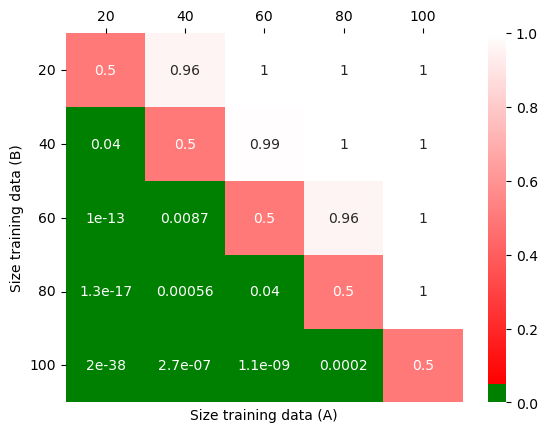

In [27]:
import matplotlib.colors as mcolors

#mask = np.triu(np.ones_like(result_df, dtype=bool))

cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_colormap',
    [(0, 'green'),  # start with green
     (0.05, 'green'),  # green for values < 0.05
     (0.05, 'red'),  # red at 0.05
     (1, 'white')]  # white at 1
)

ax = sns.heatmap(result_df, annot=True, cmap= cmap)

ax.xaxis.tick_top()
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xticklabels([20, 40, 60, 80, 100], fontsize=10)
ax.set_yticklabels([20, 40, 60, 80, 100], fontsize=10)
plt.title("")
ax.set_xlabel("Size training data (A)")
ax.set_ylabel("Size training data (B)")


## Heatmap p-values mAP scores, conf=0.25

In [28]:
sets =  ['SL_20_5_125', 'SL_40_10_100', 'SL_60_15_75', 'SL_80_20_50', 'SL_100_25_25']


set1_vals = []
for set1 in sets:
    set2_vals = []
    for set2 in sets:
        results_s1 = results100[results100['dataset'] == set1]
        results_s2 = results100[results100['dataset'] == set2]
        t_statistic, p_value = stats.ttest_ind(results_s1['metrics/mAP50(B)'], results_s2['metrics/mAP50(B)'], equal_var=True, alternative='greater')
        set2_vals.append(p_value)
    set1_vals.append(set2_vals)

result_df = pd.DataFrame(set1_vals, columns=sets, index=sets)
result_df

,SL_20_5_125,SL_40_10_100,SL_60_15_75,SL_80_20_50,SL_100_25_25
SL_20_5_125,5.000000e-01,0.728540,1.000000e+00,1.000000,1.000000
SL_40_10_100,2.714604e-01,0.500000,9.006369e-01,0.977048,0.996954
SL_60_15_75,1.222005e-09,0.099363,5.000000e-01,0.995293,1.000000
SL_80_20_50,4.294914e-18,0.022952,4.706639e-03,0.500000,0.999971
SL_100_25_25,1.125161e-33,0.003046,2.889734e-10,0.000029,0.500000


Text(50.72222222222221, 0.5, 'Size training data (B)')

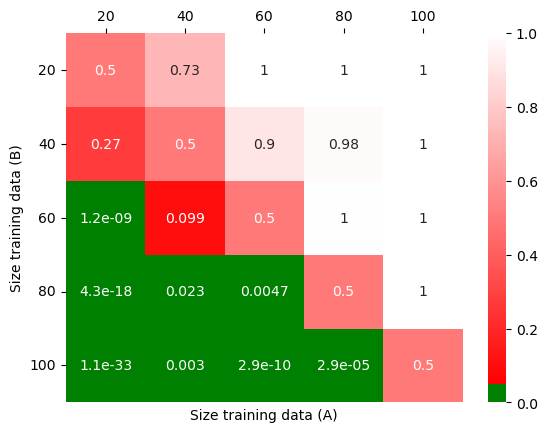

In [29]:
import matplotlib.colors as mcolors

#mask = np.triu(np.ones_like(result_df, dtype=bool))

cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_colormap',
    [(0, 'green'),  # start with green
     (0.05, 'green'),  # green for values < 0.05
     (0.05, 'red'),  # red at 0.05
     (1, 'white')]  # white at 1
)

ax = sns.heatmap(result_df, annot=True, cmap= cmap)

ax.xaxis.tick_top()
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xticklabels([20, 40, 60, 80, 100], fontsize=10)
ax.set_yticklabels([20, 40, 60, 80, 100], fontsize=10)
plt.title("")
ax.set_xlabel("Size training data (A)")
ax.set_ylabel("Size training data (B)")


 ## Second, focus is on the 0.9 threshold

In [31]:
results100c=pd.read_csv("AIResearch/resultso_val100-09.csv")

In [32]:
# Trim spaces from column names
results100c.columns = [col.strip() for col in results100c.columns]

#add F1 score
results100c['metrics/F1']=(2*results100c['metrics/precision(B)']*results100c['metrics/recall(B)'])/(results100c['metrics/precision(B)']+results100['metrics/recall(B)'])
results100c.head()

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,dataset,run,metrics/F1
0,1.0,0.823529,0.911700,0.867610,0.872019,SL_100_25_25,0,0.833333
1,1.0,0.894118,0.946944,0.892392,0.897847,SL_100_25_25,1,0.905242
2,1.0,0.858824,0.929375,0.872772,0.878432,SL_100_25_25,10,0.875188
3,1.0,0.888235,0.944053,0.890256,0.895636,SL_100_25_25,11,0.901493
4,1.0,0.852941,0.926400,0.887147,0.891072,SL_100_25_25,12,0.861073


Below the general statistics, the means decrease instead of increase as expected

In [ ]:
filtered_sets = ['SL_20_5_125', 'SL_40_10_100', 'SL_60_15_75', 'SL_80_20_50', 'SL_100_25_25']

for set_value in filtered_sets:
    results_filtered = results100c[results100c['dataset'] == set_value]

    se = np.std(results_filtered['metrics/F1']) / np.sqrt(len(results_filtered['metrics/F1']))
    mean = np.mean(results_filtered['metrics/F1'])

    print(f'Set of {set_value}, Mean: {mean:.3f}, Standard Error: {se:.3f}, '
          f'CI: {(mean - 1.96 * se):.3f}, {(mean + 1.96 * se):.3f}')

Set of SL_20_5_125, Mean: 0.914, Standard Error: 0.003, CI: 0.908, 0.920
Set of SL_40_10_100, Mean: 0.909, Standard Error: 0.005, CI: 0.899, 0.918
Set of SL_60_15_75, Mean: 0.904, Standard Error: 0.003, CI: 0.898, 0.910
Set of SL_80_20_50, Mean: 0.901, Standard Error: 0.003, CI: 0.896, 0.906
Set of SL_100_25_25, Mean: 0.874, Standard Error: 0.003, CI: 0.869, 0.879


P-values are far above 0.05

In [ ]:
from scipy import stats

filtered_sets = ['SL_40_10_100', 'SL_60_15_75', 'SL_80_20_50', 'SL_100_25_25']
results_min = results100c[results100c['dataset'] == 'SL_20_5_125']

for set_value in filtered_sets:
  results_filtered = results100c[results100c['dataset'] == set_value]
  t_statistic, p_value = stats.ttest_ind(results_filtered['metrics/F1'], results_min['metrics/F1'],  equal_var=True, alternative='greater')
  print(f'{set_value} significally bigger than SL_20_5_125: t={t_statistic:.3f}, p={p_value:.3f}')

SL_40_10_100 significally bigger than SL_20_5_125: t=-0.985, p=0.837
SL_60_15_75 significally bigger than SL_20_5_125: t=-2.397, p=0.991
SL_80_20_50 significally bigger than SL_20_5_125: t=-3.311, p=0.999
SL_100_25_25 significally bigger than SL_20_5_125: t=-9.915, p=1.000
